In [1]:
# Importing Dependencies
import os
import json
import requests
import torch
import torch.nn.functional as F
from typing import List
from pymongo import MongoClient
from IPython.display import display, Image
import nltk
from nltk.corpus import stopwords

In [2]:
# Download the NLTK stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [3]:
# Create a MongoDB client
client = MongoClient('mongodb://localhost:27017')  # replace with your connection string

# Create a database and a collection within the database
db = client['scene-sense']
embeddings_collection = db['embeddings']

In [4]:
def send_images(directory):
    files = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            # Check if the image path already exists in the database
            if embeddings_collection.count_documents({'image_path': image_path}, limit = 1) == 0:
                with open(image_path, 'rb') as f:
                    # Append a tuple to the list with the filename and file data
                    files.append(('images', (filename, f.read(), 'image/jpeg')))  # or 'image/png'

    if files:  # if there are any new images
        response = requests.post('http://localhost:8000/image_embeddings/', files=files)

        if response.status_code == 200:
            embeddings = response.json()['image_embeddings']

            for i, filename in enumerate([file[1][0] for file in files]):
                document = {
                    'image_path': os.path.join(directory, filename),
                'embedding': embeddings[i]
                }
                embeddings_collection.insert_one(document)
        else:
            print(f'Error while sending images: {response.text}')

In [5]:
def send_text(prompt):
    data = {"prompt": prompt}
    response = requests.post('http://localhost:8000/text_embeddings/', json=data)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error while sending text: {response.text}')
        return None

In [6]:
# Search for similar images given a query in DB
def get_similar_images(text_embedding: str, similarity_threshold: float = 0.22) -> List[str]:
    # Processing text embeddings
    text_embedding = torch.tensor(text_embedding)

    # Get all embeddings from the database
    documents = embeddings_collection.find()
    
    # Compute similarities with all image embeddings and get all that are above the threshold
    similar_images = []
    for document in documents:
        image_path = document['image_path']
        image_embeddings = torch.tensor(document['embedding'])
        similarity = F.cosine_similarity(text_embedding, image_embeddings)
        if similarity.item() > similarity_threshold:
            similar_images.append((similarity.item(), image_path))
    
    # Sort by similarity score
    similar_images = sorted(similar_images, key=lambda x: x[0], reverse=True)
    
    # Print and display images
    for sim, path in similar_images:
        print(f"Similarity: {sim}, Image Path: {path}")
        display(Image(filename=path))

In [7]:
def compute_similarity_threshold(prompt: str, base_threshold: float = 0.23, increment: float = 0.015) -> float:
    words = [word for word in prompt.split() if word not in stop_words]
    num_words = len(words)
    return base_threshold + num_words * increment

In [8]:
# Send images to the FastAPI server and store the returned embeddings
send_images('D:\AIML\gimmick\Scene-Sense\sample_images')

In [12]:
# Send a text prompt to the FastAPI server and store the returned embedding
prompt = "sunset"
text_embedding = send_text(prompt)
text_embedding = text_embedding['text_embedding']

In [13]:
# compute the similarity threshold based on the number of words in the prompt
similarity_threshold = compute_similarity_threshold(prompt)

Similarity: 0.2717079222202301, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1503162894963-8c333941fb01.jpg


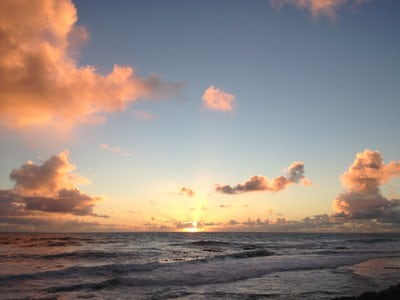

Similarity: 0.27096354961395264, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1525531845240-05c911ed9940.jpg


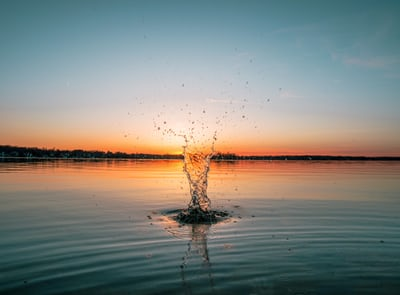

Similarity: 0.2608203887939453, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1637248921272-55cb27d12a31.jpg


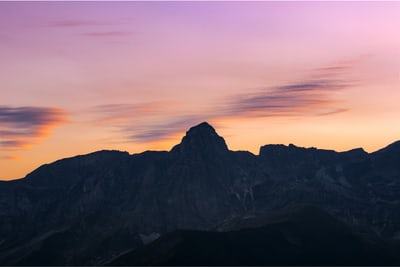

Similarity: 0.26070940494537354, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1600288214715-7c9e3127c3c2.jpg


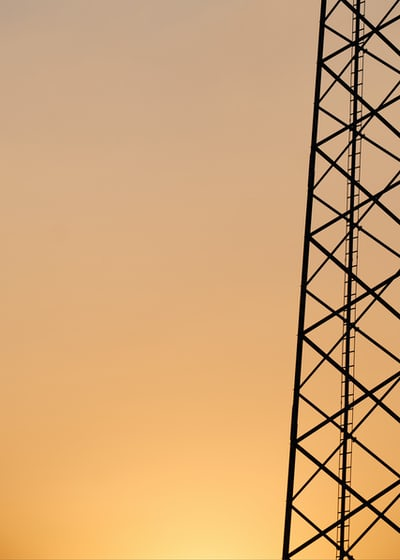

Similarity: 0.25687795877456665, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1638111963063-9dc8f1afa9b9.jpg


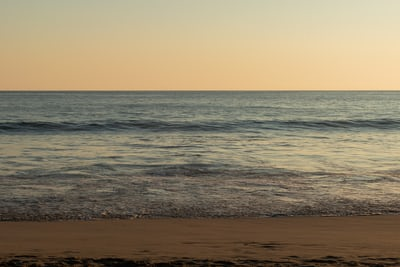

Similarity: 0.25002652406692505, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1562374184-a71b175917b0.jpg


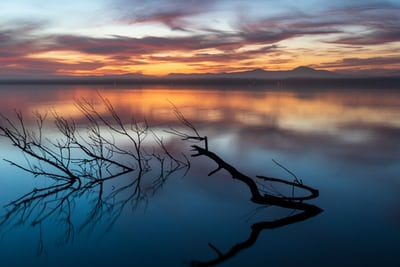

Similarity: 0.2488461136817932, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1635454022133-e287f3924950.jpg


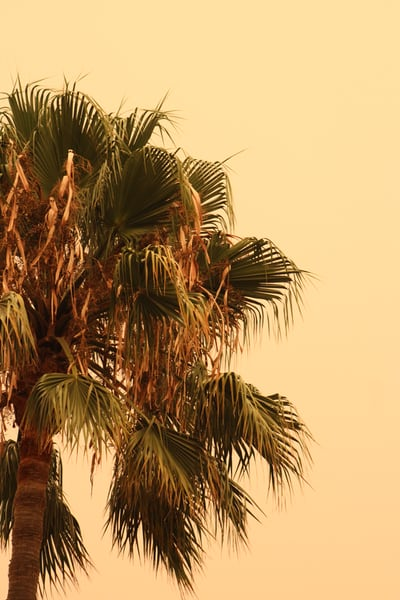

Similarity: 0.24865956604480743, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1637262067120-e91737ed40a0.jpg


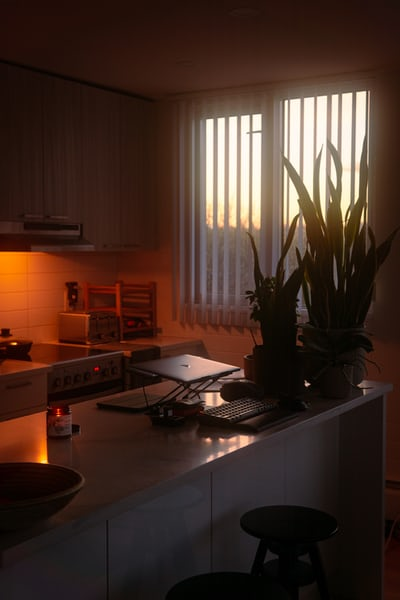

Similarity: 0.24857039749622345, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1638108820168-77c13bd437bd.jpg


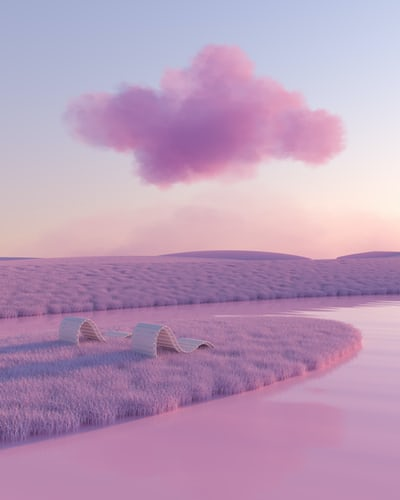

Similarity: 0.2475336194038391, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1525950585137-7ccabbf3ed62.jpg


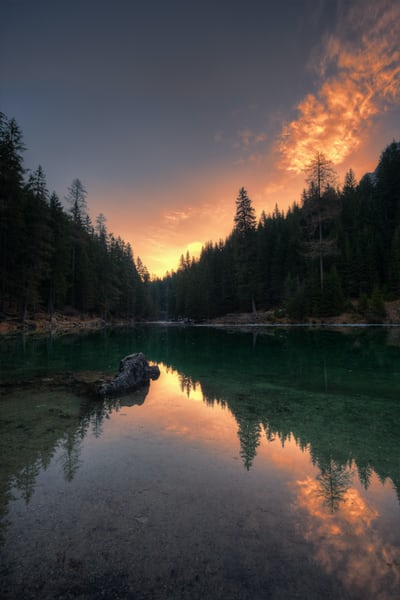

Similarity: 0.24737216532230377, Image Path: D:\AIML\gimmick\Scene-Sense\sample_images\photo-1635248426315-4f4f4f1440ff.jpg


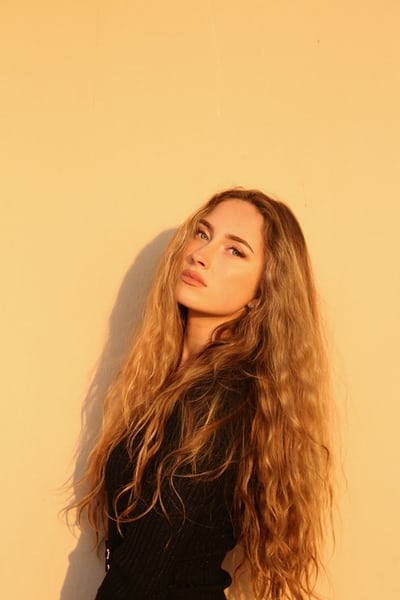

In [14]:
# Get similar images from the database
get_similar_images(text_embedding, similarity_threshold)